In [1]:
%run setup.py

In [2]:
dataframes['bologna'][dataframes['bologna'].isnull().any(axis=1)]

,date,TG,TN,TX,HU,PP,QQ,RR,CO,NH3,NMVOC,NO2,NO,O3,PANS,PM10,PM2.5,SO2
1154,2020-02-29,6.63,2.46,10.37,40.41,1016.39,114.34,0.0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


In [2]:
def impute_median(data):
    from sklearn.impute import SimpleImputer

    imputer = SimpleImputer(strategy='median')

    for province, df in data_prov_pairs:
        df[numerics] = imputer.fit_transform(df[numerics])
        
        dataframes[province] = df
    
    return dataframes

In [3]:
dataframes = impute_median(dataframes)

In [4]:
from scipy.signal import savgol_filter

def smooth(window, window_pp, poly_pp, poly = 2):
        
    for province, df in data_prov_pairs:
        
        for column in df[numerics].columns:
            # Extract numerical values from the DataFrame
            values = df[column].values
            
            # Apply Savitzky-Golay filter to the numerical values
            # for PP we need higher smooting due to outliers
            if column == 'PP':
                window = window_pp
                poly = poly_pp
                
            smoothed_values = savgol_filter(values, window, poly)
            # Update the DataFrame with the smoothed values
            df[column] = smoothed_values
            
        dataframes[province] = df

smooth(window = 10, window_pp = 25, poly_pp = 5)


In [5]:
def concat_group(groups, group_name: str):
    # Create an empty list to store modified dataframes
    dfs = []

    # Iterate through the dictionary values and groups labels
    for df, group in zip(datasets, groups):
        
        # Add a 'group' column
        df[group_name] = group
        
        # Append the modified dataframe to the list
        dfs.append(df)
    
    # Concatenate all dataframes in the list along the rows
    full_df = pd.concat(dfs, ignore_index=True)
    full_df
    
    return full_df

In [7]:
def plot_group(subfolder: str, vars, group: str, full_df):
    # subfolder should be a string indicating the name of the subfolder in the figures_folder
    # vars should be the list containing the variable names, therefore either pollutants, mets, numerics
    # group should be the variable we want to group by (eg: province, clusters,...)
    # to group we need to have created the full dataframe before with the specific group variable
    
    sns.set(style="whitegrid")
    figures = R'figures'
    figures_folder = os.path.join(path, figures)
    output_folder = os.path.join(figures_folder, subfolder)
    os.makedirs(output_folder, exist_ok=True)

    for var in vars:
        
        # Plot the time series for each province
        plt.figure(figsize=(12, 6))
        sns.lineplot(x='date', y=var, hue=full_df[group], data=full_df)

        plt.title(f'Meteorological Information Over Time by {group}')
        plt.xlabel('Date')
        plt.ylabel(var)
        plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
        
        save_path = os.path.join(output_folder, f'{var}.png')
        plt.savefig(save_path, bbox_inches='tight')
        
        plt.show()

In [10]:
full_df = concat_group(provinces, 'province')

In [ ]:
plot_group('smooth_series', numerics, 'province', full_df)

In [6]:
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from sklearn.preprocessing import MinMaxScaler

In [11]:
# let's normalize the numerical features of the dataframe
for df in datasets:
    df[pollutants] = MinMaxScaler().fit_transform(df[pollutants])

In [12]:
# Prepare input data
X = []

for df in datasets:
    group_data = df[pollutants].values
    
    group_data = np.expand_dims(group_data, axis=0)
    X.append(group_data)

# Stack the list of arrays to create a 3D array
X = np.vstack(X)

In [15]:
inertia = []
silhouette = []
K = list(range(2, 9))

for k in K:
    km = TimeSeriesKMeans(n_clusters=k, n_init=5, metric='dtw', random_state=0)
    
    labels = km.fit_predict(X)
    
    silhouette_avg = silhouette_score(X, labels, metric='dtw')
    
    inertia.append(km.inertia_)
    silhouette.append(silhouette_avg)

: 

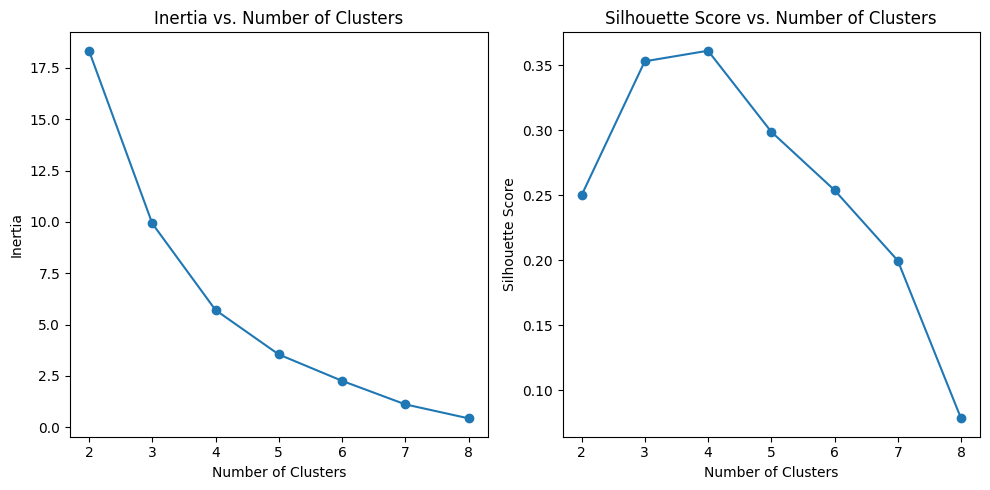

In [66]:
# Plotting inertia vs slihouette
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(K, inertia, marker='o')
plt.title('Inertia vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')

plt.subplot(1, 2, 2)
plt.plot(K, silhouette, marker='o')
plt.title('Silhouette Score vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')

plt.tight_layout()
figures_folder = os.path.join(path, R'figures')
plt.savefig(os.path.join(figures_folder, 'inertia_silhouette.png'))
plt.show()

In [13]:
km4 = TimeSeriesKMeans(n_clusters=4, n_init=5, metric='dtw', random_state=0)

clusters = km4.fit_predict(X)

In [14]:
def table_clusters(provinces = provinces, clusters = clusters):
    # Specify the results folder
    results = R"results"
    results_path = os.path.join(path, results)
    
    # Create a DataFrame
    cluster_df = pd.DataFrame(list(zip(provinces, clusters)), columns=['Province', 'Cluster'])
    
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(5, 5))

    # Hide the axes
    ax.axis('off')

    # Create a table and add it to the axis
    table = ax.table(cellText=cluster_df.values, colLabels=cluster_df.columns,
                    cellLoc='center', loc='center', edges = 'open')

    # Make column labels bold
    for (i, j), cell in table.get_celld().items():
        if i == 0:
            cell.set_text_props(fontweight='bold')

    # Adjust column width
    table.auto_set_column_width([0, 1])

    # Adjust the position of the table within the figure
    table.set_fontsize(13)  # Adjust font size
    table.scale(1, 2)  # Scale the table

    save_file = os.path.join(results_path, 'cluster_provinces.png')
    # Save the figure as a PNG image in the specified folder
    fig.savefig(save_file, bbox_inches='tight', pad_inches=0.5, dpi=300)

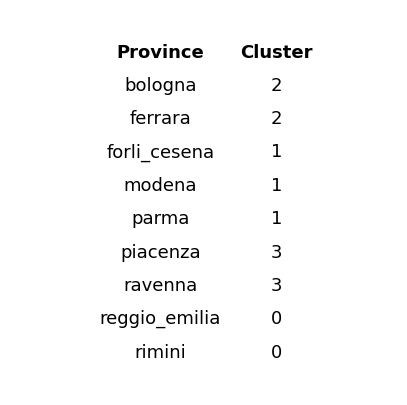

In [15]:
table_clusters()

In [13]:
df_cluster = concat_group(clusters, 'cluster')

In [14]:
def summary(full_df):
    from pandas.plotting import table
    
    grouped_df = full_df[['cluster'] + pollutants].groupby('cluster')
    summary_stats = grouped_df.describe()

    stats_folder = R'results\statistics'
    stats_path = os.path.join(path, stats_folder)
    os.makedirs(stats_path, exist_ok=True)
    
    # Iterate through pollutants and save styled tables as images
    for variable in pollutants:
        selected_stats = summary_stats[variable][['count', 'mean', 'std']]
        selected_stats = selected_stats.reset_index()
        
        # Add a new column 'cluster' with values 0, 1, 2, 3
        selected_stats['cluster'] = [0, 1, 2, 3]

        # prepare columns to ensure maximum 4 digits
        selected_stats['mean'] = round(selected_stats['mean'], 4)
        # ensure integers do not show decimal points by converting them to strings
        selected_stats['count'] = selected_stats['count'].astype(int).astype(str)
        selected_stats['cluster'] = selected_stats['cluster'].astype(str)
        
        # Move 'cluster' column to the first position
        selected_stats = selected_stats[['cluster', 'count', 'mean', 'std']]

        # Plotting parameters
        fig, ax = plt.subplots(figsize=(6, 4))
        ax.axis('off')  # Turn off axis

        cell_data = [selected_stats.columns] + selected_stats.values.tolist()
        table = ax.table(cellText=cell_data, loc='center', cellLoc='center', colLabels=None, edges='open')

        # Adjust column width
        table.auto_set_column_width([0, 1])

        # Adjust the position of the table within the figure
        table.set_fontsize(15)  # Adjust font size
        table.scale(1, 1.5)  # Scale the table
        
        # Add a title
        ax.set_title(f"Summary Statistics for {variable}", fontsize=18, y=0.9)

        # Make column labels bold
        for (i, j), cell in table.get_celld().items():
            if i == 0:
                cell.set_text_props(fontweight='bold')
    
        # Save the plot as an image
        save_name = os.path.join(stats_path, f'{variable}_table.png')
        plt.savefig(save_name, bbox_inches='tight', pad_inches=0.2)
        plt.show()

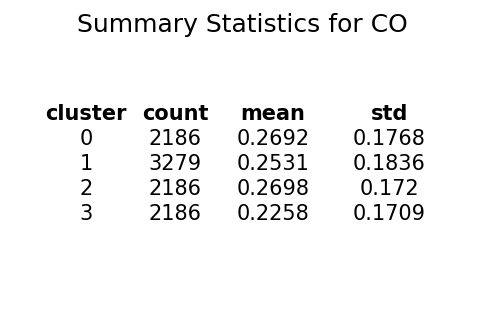

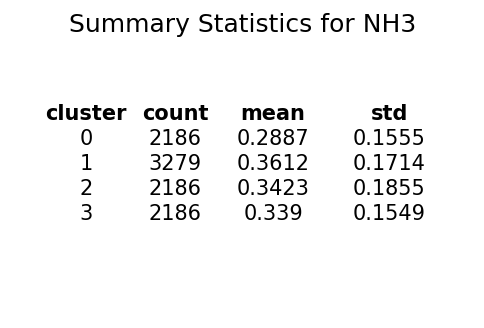

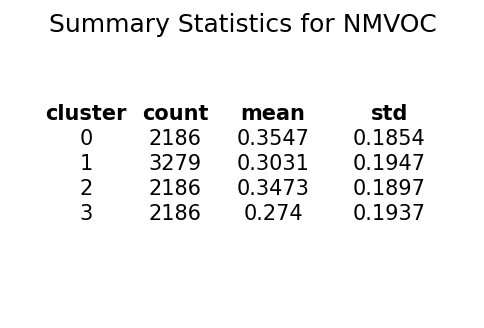

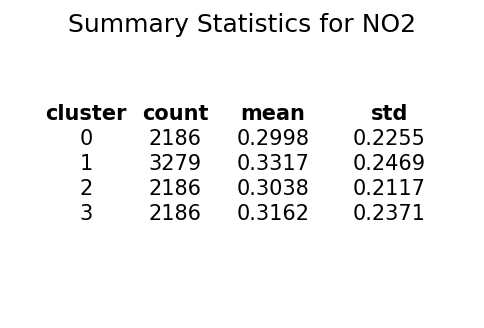

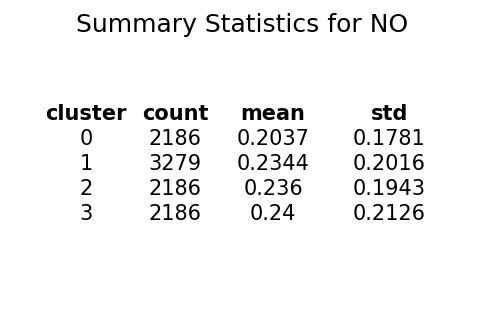

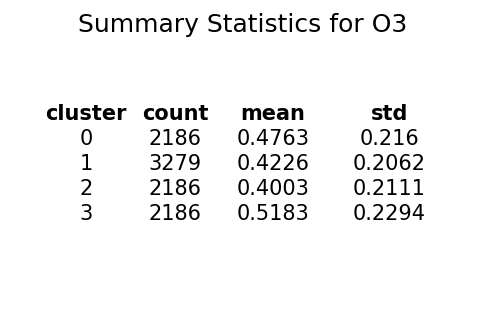

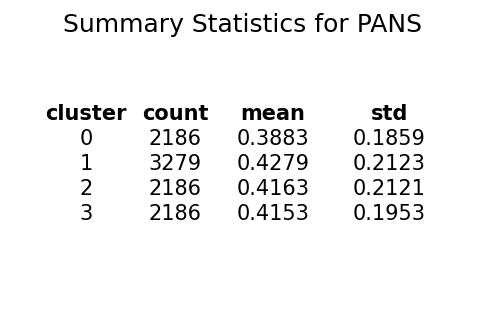

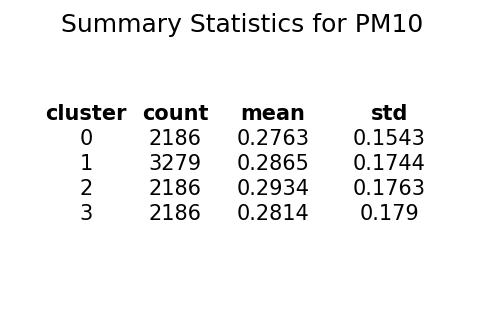

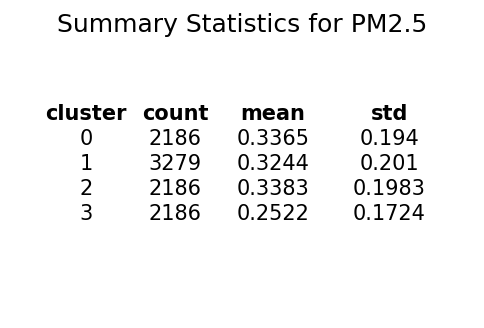

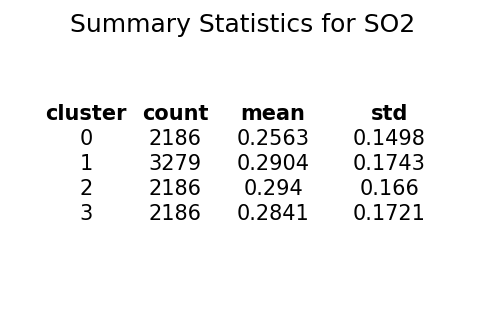

In [15]:
summary(df_cluster)